## MIT Movie Dataset - Conditional Random Field Model

This notebook contains the Conditional Random Field model with additional feature engineering covered in the "Text Analytics with Python" textbook by Sarkar. 

In [ ]:
import pandas as pd
import numpy as np

# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

os.chdir('/content/drive/My Drive/Colab Notebooks/DAAN888/data')
#os.chdir('/content/drive/My Drive/DAAN888/data')
os.getcwd()

'/content/drive/My Drive/Colab Notebooks/DAAN888/data'

In [ ]:
model_dir = '/content/drive/My Drive/Colab Notebooks/DAAN888/models/'
data_dir = '/content/drive/My Drive/Colab Notebooks/DAAN888/data/'

### Load Data

In [ ]:
import pickle 

with open('mitmovie.pickle', 'rb') as handle:
    dataset = pickle.load(handle)

In [ ]:
dataset.keys()

dict_keys(['train_tokens', 'train_labels', 'test_tokens', 'test_labels'])

In [ ]:
# first row in train set
list(zip(dataset['train_tokens'][0], dataset['train_labels'][0]))

[('what', 'O'),
 ('movies', 'O'),
 ('star', 'O'),
 ('bruce', 'B-ACTOR'),
 ('willis', 'I-ACTOR')]

In [ ]:
# first row in test set
list(zip(dataset['test_tokens'][0], dataset['test_labels'][0]))

[('are', 'O'),
 ('there', 'O'),
 ('any', 'O'),
 ('good', 'O'),
 ('romantic', 'B-GENRE'),
 ('comedies', 'I-GENRE'),
 ('out', 'O'),
 ('right', 'B-YEAR'),
 ('now', 'I-YEAR')]

### Make Word Features

IS THIS RIGHT?


The engineered features for each word will be:

* bias
* lower case version of word
* last three characters of word
* last two characters of word
* if word is upper case
* if word is title cased
* if word is digit
* the previous words in lower case
* if the previous word is title cased
* if the previous word is upper case
* if end of sentence (EOS)
* if beginning of sentence (BOS)


In [ ]:
def word2features(sent, i):
    word = sent[i][0]
#    postag = sent[i][1]

    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
#        'postag': postag,
#        'postag[:2]': postag[:2],
    }
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
#            '-1:postag': postag1,
#            '-1:postag[:2]': postag1[:2],
        })
    else:
        features['BOS'] = True

    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
#            '+1:postag': postag1,
#            '+1:postag[:2]': postag1[:2],
        })
    else:
        features['EOS'] = True

    return features


def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

#def sent2labels(sent):
#    return [label for token, postag, label in sent]

def sent2labels(sent):
    return [label for token, label in sent]

Put training and test data in format for feature engineering.


In [ ]:
train = []
for tokens, labels in zip(dataset['train_tokens'], dataset['train_labels']):
  train.append(list(zip(tokens, labels)))


test = []
for tokens, labels in zip(dataset['test_tokens'], dataset['test_labels']):
  test.append(list(zip(tokens, labels)))

In [ ]:
train[0]

[('what', 'O'),
 ('movies', 'O'),
 ('star', 'O'),
 ('bruce', 'B-ACTOR'),
 ('willis', 'I-ACTOR')]

In [ ]:
# illustration of features for first sentence
sent2features(train[0])

In [ ]:
import numpy as np

X_train = np.array([sent2features(s) for s in train])
X_test = np.array([sent2features(s) for s in test])
y_train = np.array([sent2labels(s) for s in train])
y_test = np.array([sent2labels(s) for s in test])

X_train.shape, X_test.shape, len(train), len(test)

((9775,), (2443,), 9775, 2443)

In [ ]:
y_train[0]

['O', 'O', 'O', 'B-ACTOR', 'I-ACTOR']

## Model 1 Baseline

### Train Model

In [ ]:
!pip install sklearn-crfsuite

     |████████████████████████████████| 747kB 3.9MB/s 


In [ ]:
model_name = 'mitmovie_crf/crf_baseline'

In [ ]:
import sklearn_crfsuite


crf = sklearn_crfsuite.CRF(algorithm='lbfgs', # Gradient descent using the L-BFGS method
                           c1 = 0.1, # l1 regularization
                           c2 = 0.1, # l2 regularization
                           max_iterations=100,
                           all_possible_transitions=True,
                           verbose=True)

In [ ]:
from datetime import datetime

start = datetime.now()

crf.fit(X_train, y_train)

print()
print('Time to train: ', datetime.now() - start)

loading training data to CRFsuite: 100%|██████████| 9775/9775 [00:01<00:00, 9740.05it/s]



Feature generation
type: CRF1d
feature.minfreq: 0.000000
feature.possible_states: 0
feature.possible_transitions: 1
0....1....2....3....4....5....6....7....8....9....10
Number of features: 39593
Seconds required: 0.206

L-BFGS optimization
c1: 0.100000
c2: 0.100000
num_memories: 6
max_iterations: 100
epsilon: 0.000010
stop: 10
delta: 0.000010
linesearch: MoreThuente
linesearch.max_iterations: 20

Iter 1   time=0.64  loss=248065.78 active=39005 feature_norm=1.00
Iter 2   time=1.34  loss=177667.20 active=38769 feature_norm=2.67
Iter 3   time=0.38  loss=173467.22 active=37761 feature_norm=2.49
Iter 4   time=0.38  loss=166872.47 active=38626 feature_norm=2.75
Iter 5   time=0.36  loss=119607.30 active=38593 feature_norm=8.66
Iter 6   time=0.38  loss=97207.15 active=38886 feature_norm=13.35
Iter 7   time=0.41  loss=85319.34 active=39109 feature_norm=13.75
Iter 8   time=0.41  loss=76135.53 active=39190 feature_norm=15.41
Iter 9   time=0.41  loss=69178.11 active=38775 feature_norm=20.58
Iter 

In [ ]:
from joblib import dump, load

# save the model
dump(crf, model_dir + model_name) 

['/content/drive/My Drive/Colab Notebooks/DAAN888/models/mitmovie_crf_baseline']

### Evaluate Model

In [ ]:
from joblib import load

# reload the model
crf = load( model_dir + model_name )

In [ ]:
# predict on the test set
y_pred = crf.predict(X_test)
print(y_pred[0])

['O', 'O', 'O', 'O', 'B-GENRE', 'I-GENRE', 'O', 'O', 'O']


In [ ]:
print(y_test[0])

['O', 'O', 'O', 'O', 'B-GENRE', 'I-GENRE', 'O', 'B-YEAR', 'I-YEAR']


In [ ]:
from sklearn_crfsuite import metrics

class_report = metrics.flat_classification_report(y_test, y_pred)

f = open(model_dir + model_name + '_class_report_test.txt', 'w') 
print(class_report, file=f ) 
f.close() 

print(class_report)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                   precision    recall  f1-score   support

          B-ACTOR       0.90      0.93      0.91       812
      B-CHARACTER       0.70      0.53      0.60        90
       B-DIRECTOR       0.91      0.84      0.87       456
          B-GENRE       0.93      0.95      0.94      1117
           B-PLOT       0.68      0.64      0.66       491
         B-RATING       0.98      0.97      0.97       500
B-RATINGS_AVERAGE       0.93      0.87      0.90       451
         B-REVIEW       0.38      0.14      0.21        56
           B-SONG       0.68      0.52      0.59        54
          B-TITLE       0.77      0.79      0.78       562
        B-TRAILER       0.81      0.83      0.82        30
           B-YEAR       0.95      0.94      0.95       720
          I-ACTOR       0.88      0.92      0.90       862
      I-CHARACTER       0.66      0.44      0.53        75
       I-DIRECTOR       0.90      0.84      0.87       496
          I-GENRE       0.82      0.70      0.76       

In [ ]:
!pip install seqeval

In [ ]:
from seqeval.metrics import classification_report as classification_report_seqeval

seq_class_report = classification_report_seqeval(y_test, y_pred)

f = open(model_dir + model_name +  '_seq_class_report_test.txt', 'w') 
print(seq_class_report, file=f ) 
f.close() 

print(seq_class_report)

                 precision    recall  f1-score   support

          ACTOR       0.88      0.91      0.89       812
      CHARACTER       0.70      0.53      0.60        90
       DIRECTOR       0.90      0.84      0.87       456
          GENRE       0.90      0.92      0.91      1117
           PLOT       0.66      0.62      0.64       491
         RATING       0.93      0.92      0.93       500
RATINGS_AVERAGE       0.86      0.80      0.83       451
         REVIEW       0.38      0.14      0.21        56
           SONG       0.59      0.44      0.51        54
          TITLE       0.76      0.77      0.76       562
        TRAILER       0.81      0.83      0.82        30
           YEAR       0.94      0.94      0.94       720

      micro avg       0.86      0.84      0.85      5339
      macro avg       0.77      0.72      0.74      5339
   weighted avg       0.85      0.84      0.85      5339



### Interpret Model

In [ ]:
!pip install eli5

     |████████████████████████████████| 112kB 2.7MB/s 


In [ ]:
import eli5

In [ ]:
eli5.show_weights(crf, top=10)

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


From \ To,O,B-ACTOR,I-ACTOR,B-CHARACTER,I-CHARACTER,B-DIRECTOR,I-DIRECTOR,B-GENRE,I-GENRE,B-PLOT,I-PLOT,B-RATING,I-RATING,B-RATINGS_AVERAGE,I-RATINGS_AVERAGE,B-REVIEW,I-REVIEW,B-SONG,I-SONG,B-TITLE,I-TITLE,B-TRAILER,I-TRAILER,B-YEAR,I-YEAR
O,3.243,2.93,-4.396,2.311,-3.664,2.667,-3.553,1.838,-3.61,2.221,-5.777,1.811,-3.712,2.417,-4.889,1.445,-3.064,1.674,-3.413,2.493,-5.025,1.275,-1.535,1.938,-4.495
B-ACTOR,1.045,-1.844,8.937,-0.087,-0.233,-0.102,-0.81,-0.399,0.0,-0.789,-0.914,-0.211,0.0,-0.218,-0.373,-0.071,0.0,0.0,0.0,-0.689,-0.969,0.0,0.0,-0.03,0.0
I-ACTOR,1.18,-0.877,5.075,0.0,-1.056,-0.776,-1.411,1.313,-0.947,1.17,-2.597,0.919,-0.821,0.545,-2.064,0.346,-1.0,-0.06,-1.049,-1.289,-2.014,0.0,-0.138,1.091,-1.115
B-CHARACTER,0.353,-0.84,-0.313,-0.65,6.594,-0.086,-0.296,-1.346,-0.002,0.552,-1.032,-0.417,0.0,-0.251,-0.19,-0.047,0.0,-0.064,-0.006,0.188,-1.161,0.0,0.0,-0.211,-0.033
I-CHARACTER,0.384,0.006,-0.264,-0.853,5.84,0.0,-0.094,-0.274,0.0,0.521,-1.117,-0.302,0.0,-0.077,-0.265,-0.198,0.0,-0.142,0.0,-1.076,-1.386,-0.025,0.0,-0.513,-0.163
B-DIRECTOR,0.121,-1.139,-1.335,-0.424,-0.544,-2.283,7.392,-0.845,-0.201,-0.379,-1.27,-0.906,-0.412,-0.638,-0.459,-0.454,-0.482,-0.486,-0.484,-0.229,-1.268,-0.124,0.0,-0.282,-0.28
I-DIRECTOR,1.43,-0.674,-0.825,-0.179,-0.362,-0.446,5.318,1.691,-0.219,0.534,-1.213,0.481,-0.389,0.534,-1.014,0.319,-0.446,-0.304,-0.296,-0.195,-1.18,-0.022,0.0,1.243,-0.341
B-GENRE,1.341,0.303,-0.866,-0.392,-0.645,0.798,-1.108,-4.65,5.623,1.389,-1.879,0.636,-0.891,1.237,-1.353,-0.939,-0.723,-0.529,-0.492,-0.989,-1.723,-1.613,0.0,0.997,-0.666
I-GENRE,0.861,-0.557,-0.901,-0.163,-0.176,0.129,-0.635,-2.434,5.674,0.172,-1.524,-0.085,-0.595,0.022,-0.819,-0.277,-0.124,-0.0,-0.154,0.001,-1.127,0.56,0.0,0.631,-0.481
B-PLOT,0.449,0.295,-1.377,-0.102,-0.922,-0.404,-1.652,0.436,-1.508,-2.488,5.125,-0.544,-0.714,0.379,-1.32,-1.04,-0.673,-1.128,-0.758,-1.737,-1.958,-0.599,-0.121,-0.472,-0.918


## Model 2 Hyperparameter Optimization

In [ ]:
!pip install sklearn_crfsuite
import scipy.stats
import sklearn_crfsuite
from sklearn.metrics import make_scorer
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics

     |████████████████████████████████| 747kB 6.4MB/s 


### Run Randomized Search

In [ ]:
#from sklearn.grid_search import RandomizedSearchCV
from sklearn.model_selection import learning_curve, GridSearchCV, RandomizedSearchCV

# define fixed parameters and parameters to search
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    max_iterations=100,
    all_possible_transitions=True
)

# we search a grid for c1 and c2
params_space = {
    'c1': scipy.stats.expon(scale=0.5), # grid for l1 regul
    'c2': scipy.stats.expon(scale=0.05), # grid for l2 regul
}

# use f1 for a performance metric
f1_scorer = make_scorer(metrics.flat_f1_score, average='weighted')

# define searcher
rs = RandomizedSearchCV(crf, params_space,
                        cv=3,
                        verbose=1,
                        n_jobs=-1,
                        n_iter=50,
                        scoring=f1_scorer)

# run searcher
rs.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 15.9min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 51.2min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=CRF(algorithm='lbfgs', all_possible_states=None,
                                 all_possible_transitions=True, averaging=None,
                                 c=None, c1=None, c2=None,
                                 calibration_candidates=None,
                                 calibration_eta=None,
                                 calibration_max_trials=None,
                                 calibration_rate=None,
                                 calibration_samples=None, delta=None,
                                 epsilon=None, error_sensitive=None, gamma=None,
                                 keep_...
                                 verbose=False),
                   iid='deprecated', n_iter=50, n_jobs=-1,
                   param_distributions={'c1': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f0dd5af76d8>,
                                        'c2': <scipy.stats._distn_infrastructure.rv_fr

https://sklearn-crfsuite.readthedocs.io/en/latest/tutorial.html

In [ ]:
print('best params:', rs.best_params_)
print('best CV score:', rs.best_score_)
print('model size: {:0.2f}M'.format(rs.best_estimator_.size_ / 1000000))

best params: {'c1': 0.2154902625717649, 'c2': 0.0787165771719508}
best CV score: 0.8923403356540889
model size: 1.14M


In [ ]:
model_name = 'mitmovie_crf/crf_random_search'

In [ ]:
from joblib import dump, load

# save the best model
dump(rs.best_estimator_, model_dir + model_name) 

['/content/drive/My Drive/Colab Notebooks/DAAN888/models/mitmovie_crf/crf_random_search']

### Evaluate the model

In [ ]:
#crf = rs.best_estimator_

In [ ]:
from joblib import load

# reload the model
crf = load( model_dir + model_name )

In [ ]:
# get predicted values

train_preds = crf.predict(X_train)
test_preds = crf.predict(X_test)

In [ ]:
print('TRAIN SET Classification Report')
print(metrics.flat_classification_report(y_train, train_preds))

TRAIN SET Classification Report
                   precision    recall  f1-score   support

          B-ACTOR       0.98      0.99      0.98      3220
      B-CHARACTER       0.95      0.90      0.93       385
       B-DIRECTOR       0.99      0.97      0.98      1720
          B-GENRE       0.97      0.99      0.98      4354
           B-PLOT       0.94      0.92      0.93      1927
         B-RATING       0.98      0.97      0.98      2007
B-RATINGS_AVERAGE       0.95      0.93      0.94      1869
         B-REVIEW       0.79      0.42      0.54       221
           B-SONG       0.94      0.86      0.90       245
          B-TITLE       0.96      0.96      0.96      2376
        B-TRAILER       0.84      0.95      0.89       113
           B-YEAR       0.98      0.97      0.97      2858
          I-ACTOR       0.98      0.98      0.98      3474
      I-CHARACTER       0.95      0.91      0.93       342
       I-DIRECTOR       0.99      0.98      0.98      1850
          I-GENRE      

In [ ]:
from sklearn_crfsuite import metrics

class_report = metrics.flat_classification_report(y_test, test_preds)

f = open(model_dir + model_name + '_class_report_test.txt', 'w') 
print(class_report, file=f ) 
f.close()

print()
print('TEST SET Classification Report')
print(class_report)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



TEST SET Classification Report
                   precision    recall  f1-score   support

          B-ACTOR       0.90      0.92      0.91       812
      B-CHARACTER       0.72      0.52      0.61        90
       B-DIRECTOR       0.90      0.85      0.87       456
          B-GENRE       0.93      0.95      0.94      1117
           B-PLOT       0.68      0.63      0.66       491
         B-RATING       0.98      0.97      0.97       500
B-RATINGS_AVERAGE       0.93      0.88      0.91       451
         B-REVIEW       0.39      0.16      0.23        56
           B-SONG       0.65      0.52      0.58        54
          B-TITLE       0.76      0.78      0.77       562
        B-TRAILER       0.80      0.80      0.80        30
           B-YEAR       0.95      0.94      0.95       720
          I-ACTOR       0.88      0.92      0.90       862
      I-CHARACTER       0.65      0.43      0.52        75
       I-DIRECTOR       0.89      0.85      0.87       496
          I-GENRE      

In [ ]:
!pip install seqeval

     |████████████████████████████████| 51kB 2.1MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-cp36-none-any.whl size=16171 sha256=55fb9362aeeb625a49a4de81908296a71e66159e4f1d89d248fcb48ce041e9c6
  Stored in directory: /root/.cache/pip/wheels/52/df/1b/45d75646c37428f7e626214704a0e35bd3cfc32eda37e59e5f
Successfully built seqeval


In [ ]:
from seqeval.metrics import classification_report as classification_report_seqeval

seq_class_report = classification_report_seqeval(y_test, test_preds)

f = open(model_dir + model_name +  '_seq_class_report_test.txt', 'w') 
print(seq_class_report, file=f ) 
f.close() 

print(seq_class_report)

                 precision    recall  f1-score   support

          ACTOR       0.87      0.90      0.89       812
      CHARACTER       0.72      0.52      0.61        90
       DIRECTOR       0.90      0.84      0.87       456
          GENRE       0.90      0.92      0.91      1117
           PLOT       0.65      0.61      0.63       491
         RATING       0.93      0.92      0.93       500
RATINGS_AVERAGE       0.87      0.82      0.84       451
         REVIEW       0.39      0.16      0.23        56
           SONG       0.56      0.44      0.49        54
          TITLE       0.74      0.77      0.75       562
        TRAILER       0.80      0.80      0.80        30
           YEAR       0.94      0.94      0.94       720

      micro avg       0.85      0.84      0.85      5339
      macro avg       0.77      0.72      0.74      5339
   weighted avg       0.85      0.84      0.84      5339



### Inspect Param Search Results

In [ ]:
#rs.cv_results_

In [ ]:
# rs.cv_results_['param_c1']

''

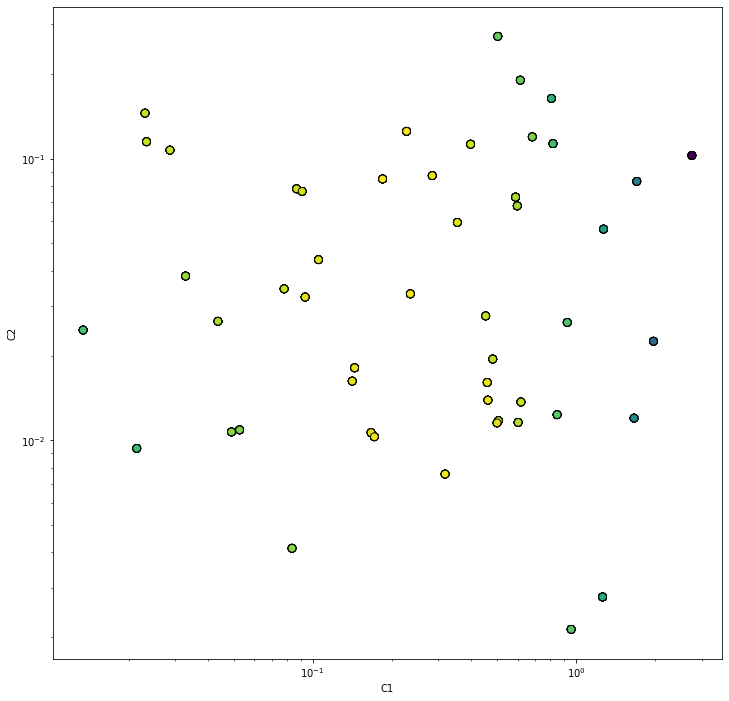

In [ ]:
import matplotlib.pyplot as plt

# get each parameter value that was run
_x = [rs.cv_results_['param_c1'] for s in rs.cv_results_]
_y = [rs.cv_results_['param_c2'] for s in rs.cv_results_]
_c = [rs.cv_results_['mean_test_score'] for s in rs.cv_results_]

fig = plt.figure()
fig.set_size_inches(12, 12)
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('C1')
ax.set_ylabel('C2')

#ax.set_title("Randomized Hyperparameter Search CV Results (min={:0.3}, max={:0.3})".format(min(_c), max(_c)))
ax.scatter(_x, _y, c=_c, s=60, alpha=0.9, edgecolors=[0,0,0])

#print("Dark blue => {:0.4}, dark red => {:0.4}".format(min(_c), max(_c)))
;

In [ ]:
#df_report.to_csv('/content/drive/My Drive/DAAN888/Results/NER_from_Scratch_MIT_Movie_Dataset.csv', index=True)

### Interpret the Model

In [ ]:
import eli5

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
eli5.show_weights(crf, top=10)

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


From \ To,O,B-ACTOR,I-ACTOR,B-CHARACTER,I-CHARACTER,B-DIRECTOR,I-DIRECTOR,B-GENRE,I-GENRE,B-PLOT,I-PLOT,B-RATING,I-RATING,B-RATINGS_AVERAGE,I-RATINGS_AVERAGE,B-REVIEW,I-REVIEW,B-SONG,I-SONG,B-TITLE,I-TITLE,B-TRAILER,I-TRAILER,B-YEAR,I-YEAR
O,3.009,3.126,-4.332,2.342,-3.378,2.742,-3.26,2.01,-3.131,2.251,-5.765,1.947,-3.009,2.441,-4.46,1.815,-2.867,1.707,-3.334,2.525,-5.122,1.294,-1.423,2.136,-4.52
B-ACTOR,0.57,-1.809,8.631,0.0,-0.431,0.0,-0.609,-0.35,0.0,-0.892,-0.92,-0.106,0.0,-0.115,0.0,0.0,0.0,0.0,0.0,-0.547,-0.991,0.0,0.0,0.0,0.0
I-ACTOR,0.98,-0.707,4.979,0.0,-1.268,-0.656,-1.194,1.404,-0.843,1.225,-2.64,0.827,-0.377,0.498,-1.554,0.682,-0.537,-0.032,-0.975,-1.161,-2.022,0.0,0.0,1.248,-0.952
B-CHARACTER,0.027,-0.729,-0.445,-0.827,6.313,0.0,-0.012,-1.127,0.0,0.472,-0.978,-0.214,0.0,-0.156,0.0,0.0,0.0,0.0,0.0,0.0,-1.167,0.0,0.0,-0.094,0.0
I-CHARACTER,0.07,0.003,-0.23,-0.768,5.573,0.0,0.0,-0.265,0.0,0.476,-1.146,-0.223,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.233,-1.395,0.0,0.0,-0.298,0.0
B-DIRECTOR,0.143,-0.597,-1.103,-0.276,-0.698,-1.976,7.968,-0.42,0.0,-0.049,-1.248,-0.704,0.0,-0.212,0.0,0.0,0.0,-0.177,-0.031,0.256,-1.134,0.0,0.0,0.0,0.0
I-DIRECTOR,1.351,-0.478,-0.65,0.0,-0.212,-0.237,5.762,1.995,0.0,0.706,-1.191,0.769,0.0,0.611,-0.333,0.824,0.0,-0.109,0.0,0.0,-1.121,0.0,0.0,1.374,-0.121
B-GENRE,1.262,0.444,-0.811,-0.276,-0.591,0.866,-0.896,-4.72,6.085,1.526,-2.058,0.881,-0.351,1.307,-0.676,-0.67,-0.436,-0.363,-0.297,-0.753,-1.596,-1.499,0.0,1.354,-0.391
I-GENRE,0.713,-0.18,-0.859,-0.0,0.0,0.167,-0.359,-2.109,6.118,0.301,-1.6,0.0,-0.058,0.0,-0.195,0.0,0.0,0.0,0.0,0.0,-1.051,0.375,0.0,0.788,-0.275
B-PLOT,0.381,0.574,-1.048,0.0,-0.875,-0.113,-1.079,0.757,-1.048,-2.395,5.078,-0.174,-0.278,0.385,-0.834,-0.596,-0.243,-0.842,-0.465,-1.469,-2.144,-0.428,0.0,-0.11,-0.75
